In [1]:
"""
This script imports necessary libraries and sets up the plotting style for calibration plots.
"""

import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import pandas as pd
import SBNDstyle
import matplotlib.pyplot as plt
plt.style.use('SBND.mplstyle')
import matplotlib.colors as mcolors
import glob
import pandas as pd


/home/rodrigoa/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## DC Plots

In [2]:
DEBUG=False

def get_data_at_OV(OV,merged=True):

    # Define the folder path
    folder_path = 'data'

    # Define the characters to search for
    characters = '_'+str(OV)

    # Search for files in the folder and its subfolders
    file_list = glob.glob(f'{folder_path}/**/*{characters}*', recursive=True)
    if DEBUG: print(file_list[:3])
    
    # Create an empty list to store the DataFrames
    dfs = []

    # Loop through the file list
    for file in file_list:
        # Read the file and convert it to a DataFrame
        df = pd.read_csv(file)  # Replace with the appropriate method based on the file format
        
        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate the DataFrames into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)
    if not merged: return dfs
    else:          return combined_df

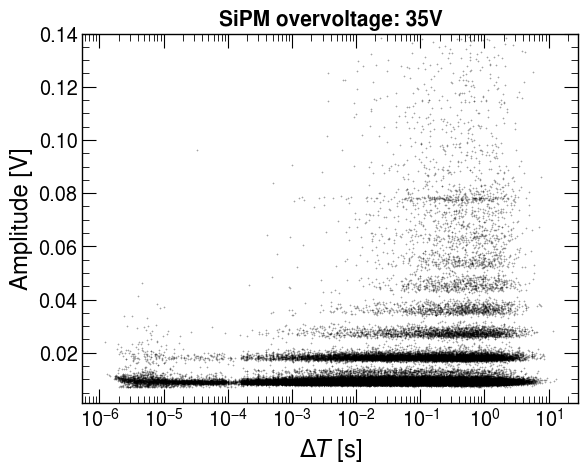

CT_raw:  12.304973183812775
AP_raw:  1.707459931488614


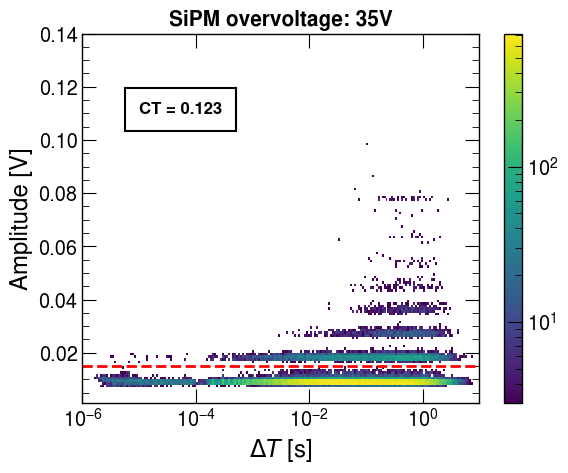

In [3]:
%matplotlib inline
# OVs      = [35,45,7]
# low_lims = [0.005,0.007,0.014]


OVs      = [35]
low_lims = [0.007]
CT_lim=0.015

# OVs      = [45]
# low_lims = [0.010]
# CT_lim=0.022

# OVs      = [7]
# low_lims = [0.013]
# CT_lim=0.035

AP_lim = 2*10**(-5)
 

for ov,low_lim in zip(OVs,low_lims):
    
    combined_df=get_data_at_OV(ov)
    
    x=combined_df["DeltaT"].array
    y=combined_df["Amplitude"].array

    x=x[y>low_lim]
    y=y[y>low_lim]

    plt.figure()
    plt.plot(x,y,'s',markersize=0.1,linestyle='None',color='black')
    plt.semilogx()
    plt.ylim(0.001,0.14)
    plt.ylabel('Amplitude [V]')
    plt.xlabel('$\Delta T$ [s]')
    plt.title("SiPM overvoltage: "+str(ov)+'V',fontsize=15,fontweight='bold')

    plt.show()

    plt.figure()

    rx=np.logspace(-6,1,200)
    ry=np.arange(0,0.2,0.001)

    plt.hist2d(x, y, bins=[rx,ry], cmap='viridis',cmin=3, norm=mcolors.LogNorm())
    plt.ylim(0.001,0.14)
    
    plt.colorbar()
    plt.semilogx()
    plt.ylabel('Amplitude [V]')
    plt.xlabel('$\Delta T$ [s]')
    
    CT_raw=sum((y>CT_lim) * (y<0.12) )/len(y)
    AP_raw=sum(x<AP_lim)/sum((x>AP_lim)*(y<CT_lim))
    
    print("CT_raw: ",CT_raw*100)
    print("AP_raw: ",AP_raw*100)
    plt.hlines(CT_lim,0.000001,10,linestyle='--',color='red')
    plt.text(0.00001,0.11,'CT = '+str(round(CT_raw,3)),color='black',fontsize=12,fontweight='bold',bbox={'edgecolor': 'black',"facecolor":"white",'pad': 10})
    
    plt.title("SiPM overvoltage: "+str(ov)+'V',fontsize=15,fontweight='bold')
    plt.show()


In [4]:
#run per run

# OVs      = [35,45,7]
# low_lim = [0.005,0.007,0.014]


# OVs      = 35
# low_lim = 0.007
# CT_lim=0.015

# OVs      = 45
# low_lim = 0.010
# CT_lim=0.022

# OV      = 7
# low_lim = 0.013
# CT_lim=0.035


OVs = [35,45,7]
low_lims = [0.007,0.010,0.013]
CT_lims = [0.015,0.022,0.035]

df_CT_AP=pd.DataFrame(columns=['OV','CT','CT STD','AP','AP STD'])

for OV,low_lim,CT_lim in zip(OVs,low_lims,CT_lims):
    AP_lim = 2*10**(-5)

    dfs=get_data_at_OV(OV,merged=False)

    CT_list=[]
    AP_list=[]

    for df in dfs:
        x=df["DeltaT"].array
        y=df["Amplitude"].array

        x=x[y>low_lim]
        y=y[y>low_lim]
        CT_raw=sum((y>CT_lim) * (y<0.12) )/len(y)
        AP_raw=sum(x<AP_lim)/sum((x>AP_lim)*(y<CT_lim))
        CT_list.append(CT_raw)
        AP_list.append(AP_raw)


    CT_list=np.array(CT_list)
    AP_list=np.array(AP_list)

    #sanity check, remove outliers
    CT_list=CT_list[CT_list<np.mean(CT_list)+2*np.std(CT_list)]
    AP_list=AP_list[AP_list<np.mean(AP_list)+2*np.std(AP_list)]

    # print("OV: ",OV)
    # print("CT_raw: ",np.mean(CT_list)*100,"+-",np.std(CT_list)*100)
    # print("AP_raw: ",np.mean(AP_list)*100,"+-",np.std(AP_list)*100)

    if OV>10:OV=OV/10
    new_row = {"OV": OV, "CT": np.mean(CT_list)*100, "CT STD": np.std(CT_list)*100, "AP": np.mean(AP_list)*100, "AP STD": np.std(AP_list)*100}

    df_CT_AP = pd.concat([df_CT_AP, pd.DataFrame([new_row])], ignore_index=True)


# df_CT_AP.to_csv('CT_AP_summary.csv',index=False)
df_CT_AP.to_excel('Summary.xlsx',sheet_name="Crosstalk and Afterpulse",index=False)


/tmp/ipykernel_29197/3536623544.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_CT_AP = pd.concat([df_CT_AP, pd.DataFrame([new_row])], ignore_index=True)


<Figure size 640x480 with 0 Axes>

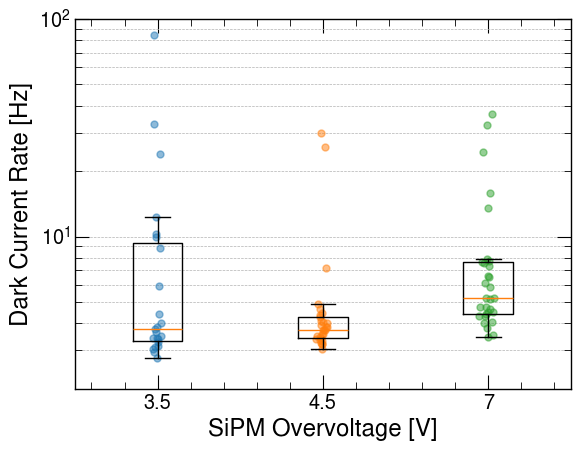

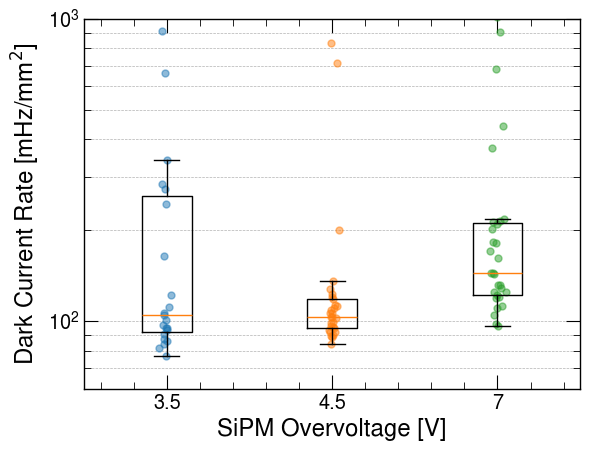

In [5]:
SiPM_side=6 #mm
active_area=SiPM_side**2 #mm^2

DC_times_Nev=pd.read_csv("DC_summary.csv") #in seconds

plt.figure()

colors=['red','blue','green']
marker=['o','s','^']
OVs=[3.5,4.5,7]

rates=[]
std=[]
for OV in OVs:
    filtered_dc_times_nev = DC_times_Nev[DC_times_Nev['OV'] == OV]
    
    rate=filtered_dc_times_nev["N_events"]/filtered_dc_times_nev["duration"] #Hz
    rates.append(rate.array)

rates_mean=np.array([np.mean(rates[i] ) for i in range(len(rates))])
rates_std=np.array([np.std(rates[i] ) for i in range(len(rates))])


plt.figure()
aux=[1,2,3]
for rate,x in zip(rates,aux):
    plt.plot(x*np.ones(len(rate))+np.random.normal(0, 0.02,len(rate)),rate,marker='o',markersize=5,linestyle='None',alpha=0.5)
    
box=plt.boxplot(rates,showmeans=False,showfliers=False);

plt.ylabel('Dark Current Rate [Hz]')

plt.xticks([1,2,3], [3.5,4.5,7]) # x axis labels
plt.xlabel('SiPM Overvoltage [V]')
plt.ylim(2,100)
plt.semilogy()
plt.grid(True,which='both',axis='y')

plt.figure()
aux=[1,2,3]

i=0
for rate,x in zip(rates,aux):
    rate=rate/active_area*1000 #mHz/mm^2
    plt.plot(x*np.ones(len(rate))+np.random.normal(0, 0.02,len(rate)),rate,marker='o',markersize=5,linestyle='None',alpha=0.5)
    
    rates[i]=rates[i]/active_area*1000 #mHz/mm^2
    i+=1;
box=plt.boxplot(rates,showmeans=False,showfliers=False);

plt.ylabel('Dark Current Rate [mHz/mm$^2$]')

plt.xticks([1,2,3], [3.5,4.5,7]) # x axis labels
plt.xlabel('SiPM Overvoltage [V]')
plt.ylim(60,1000)
plt.semilogy()
plt.grid(True,which='both',axis='y')

In [8]:
import pandas as pd
from tabulate import tabulate

for i in range(len(rates)):    rates[i]=rates[i]*active_area/1000 #mHz/mm^2

# Calculate the median of rates
rates_median = np.array([np.median(rate) for rate in rates])
rates_mean   = np.array([np.mean  (rate) for rate in rates])

data = {'SiPM Overvoltage [V]': OVs,
    'Rates Median [Hz]': rates_median,
    'Rates Mean [Hz]': rates_mean,
    'Rates Std [Hz]': rates_std}

df_DarkCurrent = pd.DataFrame(data)

# Define the constant number
constant = 1000/active_area

# Multiply the rates median and rates std columns by the constant
rates_median_modified = rates_median * constant
rates_std_modified = rates_std * constant
rates_mean_modified = rates_mean * constant

data_modified = {'SiPM Overvoltage [V]': OVs,
         'Rates Median [mHz/mm2]': rates_median_modified,
         'Rates Mean [mHz/mm2]': rates_mean_modified,
         'Rates Std [mHz/mm2]': rates_std_modified}

df_DarkCurrent_modified = pd.DataFrame(data_modified)

## Total Gain

    OV  Mean Gain x1e6  Std Gain x1e6
0  3.5        4.059247       0.058858
1  4.5        5.565050       0.070026
2  7.0        9.142513       0.067931


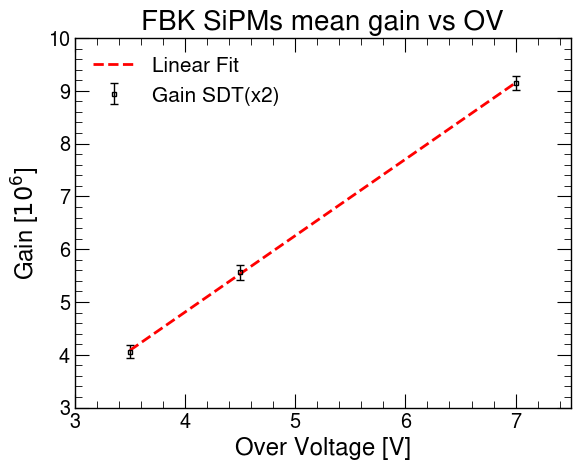

In [10]:
import matplotlib.pyplot as plt
plt.style.use('SBND.mplstyle')
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd
# plt.plot(data['OV'].array,data['Gain'].array,'^',markersize=2)

data = pd.read_csv('calibrations.csv')

grouped_data_mean = np.array(data.groupby('OV')['Gain'].mean().to_list())
grouped_data_std  = np.array(data.groupby('OV')['Gain'].std() .to_list())
OVs=unique_values = np.array(data["OV"].unique()                        )
plt.errorbar(OVs,grouped_data_mean,np.array(grouped_data_std)*2,fmt='s',markersize=3,markerfacecolor="None",capsize=3,capthick=1,elinewidth=1,ecolor="black",color="black",linewidth=0,label="Gain SDT(x2)")

slope, intercept = np.polyfit(OVs, grouped_data_mean, 1)
linear_fit = np.polyval([slope, intercept], OVs)

plt.legend(loc='upper left', fontsize=15)
plt.title('Mean Gain vs OV', fontsize=20)
plt.xlabel('OV [V]')
plt.ylabel('Gain')
plt.xlim(3, 7.5)
plt.ylim(3, 10)

plt.plot(OVs, linear_fit, '--', label='Linear Fit', color='red'
         )

plt.legend(loc='upper left', fontsize=15)
plt.title('FBK SiPMs mean gain vs OV', fontsize=20)
plt.xlabel('Over Voltage [V]')
plt.ylabel('Gain [$10^6$]')
plt.xlim(3, 7.5)
plt.ylim(3, 10)
plt.savefig("final_plots/Gain_vs_OV_total.png", bbox_inches='tight')
plt.savefig("final_plots/Gain_vs_OV_total.pdf", bbox_inches='tight')


df_gain = pd.DataFrame({'OV': OVs, 'Mean Gain x1e6': grouped_data_mean, 'Std Gain x1e6': grouped_data_std})

print(df_gain)



df_CT_AP.to_excel('Summary.xlsx',sheet_name="Crosstalk and Afterpulse",index=False)
# Open the existing Excel file
with pd.ExcelWriter('Summary.xlsx', mode='a') as writer:
    # Write the data to different sheets
    df_DarkCurrent.to_excel(writer,sheet_name="Dark Current Hz",index=False)
    df_DarkCurrent_modified.to_excel(writer, sheet_name='Dark Current mHz mm2', index=False)
    df_gain.to_excel(writer, sheet_name='Gain', index=False)


## Plotting the gain vs OV for each channel

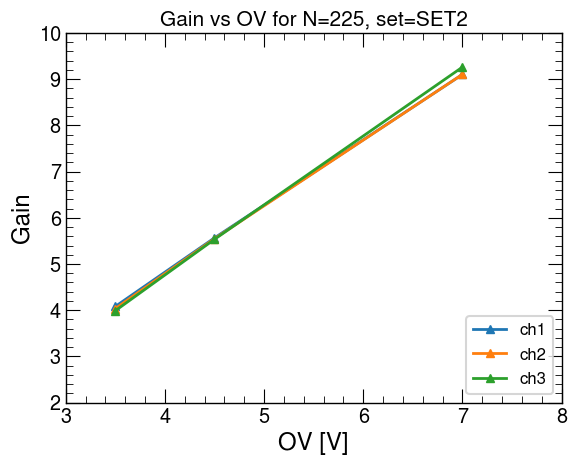

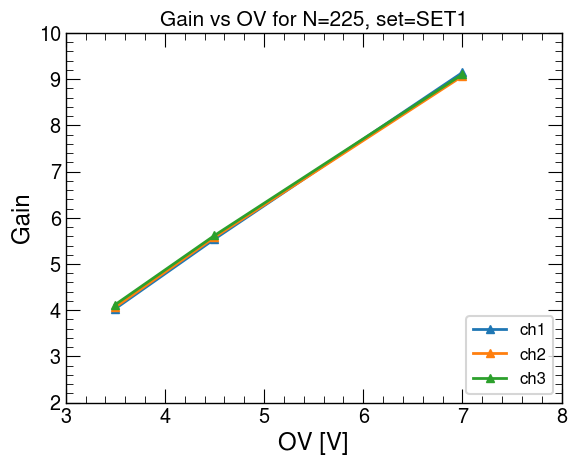

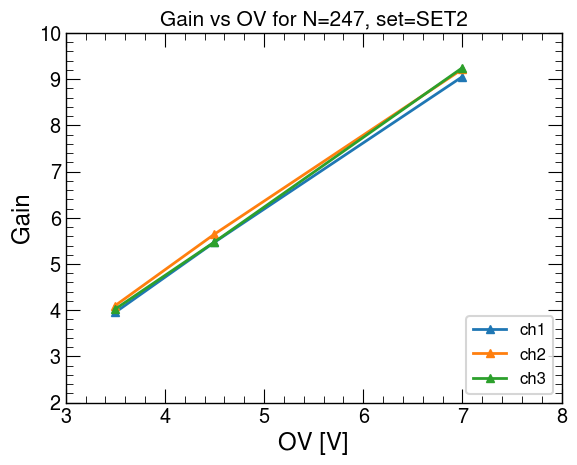

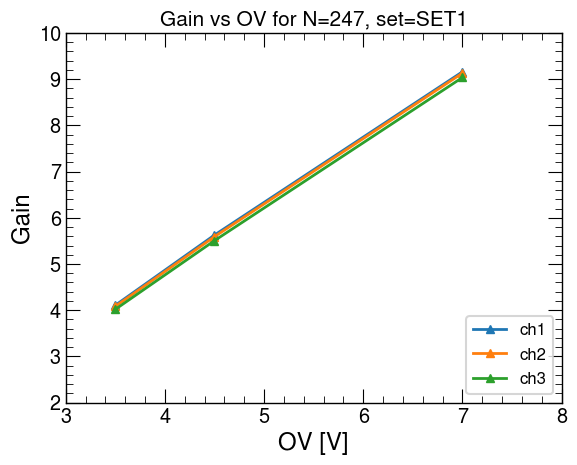

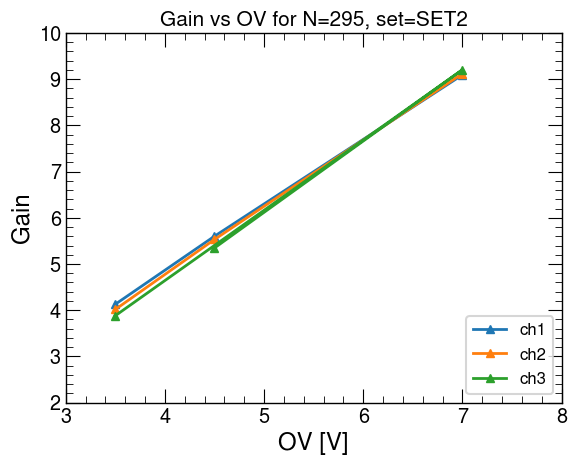

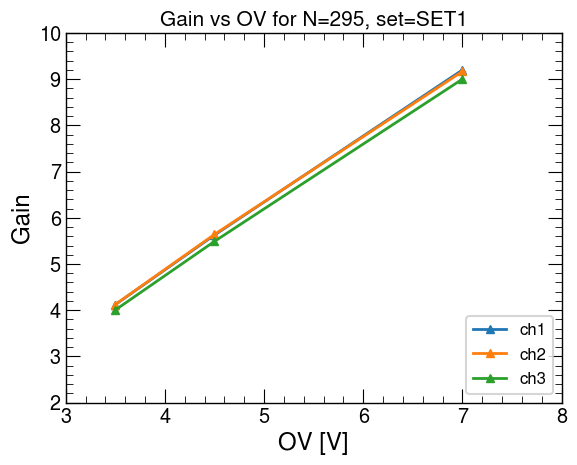

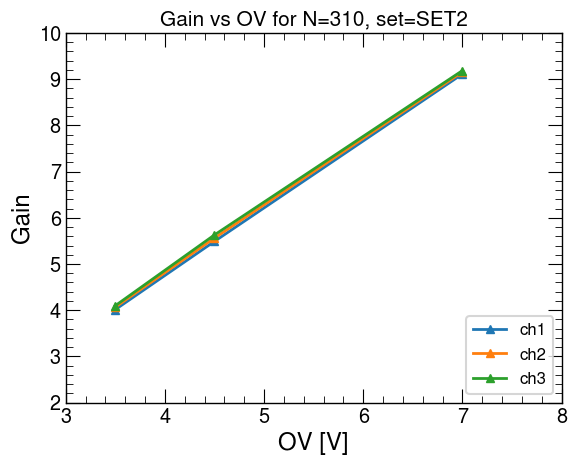

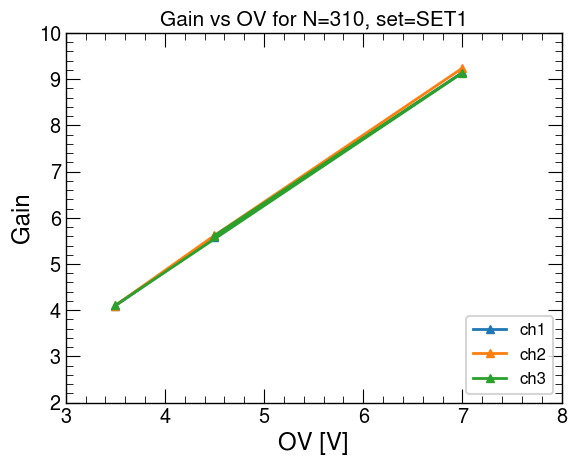

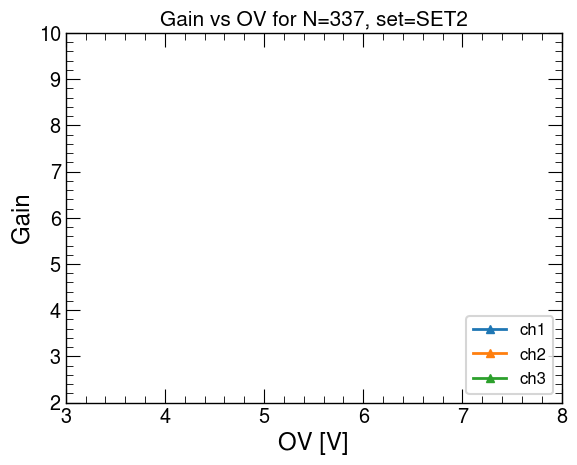

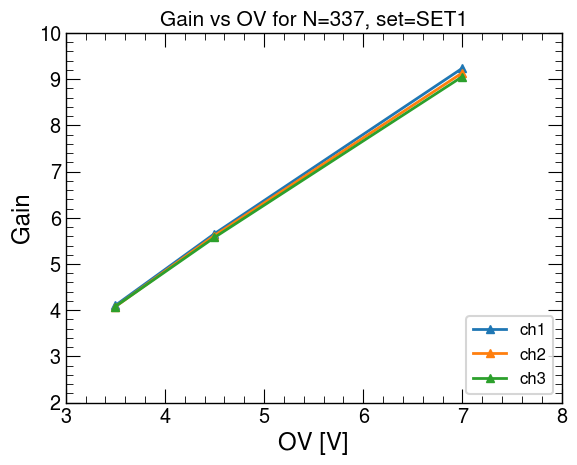

In [5]:
for N in [225,247,295,310,337]:
    for s in ["SET2","SET1"]:
        plt.figure()
        for ch in [1,2,3]:
            aux=data[(data['N']==N) & (data['set']==s) & (data['ch']==ch)]

            plt.plot(aux['OV'].array,aux['Gain'].array,'-^',label=f'ch{ch}')
            plt.title(f'Gain vs OV for N={N}, set={s}',fontsize=15)
            plt.legend(frameon=True,loc='lower right')
            plt.xlabel('OV [V]')
            plt.ylabel('Gain')
            plt.xlim(3,8)
            plt.ylim(2,10)